In [2]:
import pandas as pd
import numpy as np
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.metrics import mean_squared_error as mse
from math import sqrt


#### Read data

In [15]:
data = pd.read_csv('CovidCases.csv')
data = data.drop(data[data.Year == "Unknown"].index)
data


,Year,Month,Day,Active Count,Deceased Count,Recovered Count
0,2020,1,1,0,0,3
1,2020,1,10,0,0,1
2,2020,1,13,0,0,1
3,2020,1,16,0,0,1
4,2020,1,21,0,0,1
...,...,...,...,...,...,...
484,2021,5,29,895,0,0
485,2021,5,30,651,0,10
486,2021,5,31,842,0,1
487,2021,6,1,679,0,0


In [19]:
data['Date'] = data.Year + "-" + data.Month + "-" + data.Day
data


,Year,Month,Day,Active Count,Deceased Count,Recovered Count,Date
0,2020,1,1,0,0,3,2020-1-1
1,2020,1,10,0,0,1,2020-1-10
2,2020,1,13,0,0,1,2020-1-13
3,2020,1,16,0,0,1,2020-1-16
4,2020,1,21,0,0,1,2020-1-21
...,...,...,...,...,...,...,...
484,2021,5,29,895,0,0,2021-5-29
485,2021,5,30,651,0,10,2021-5-30
486,2021,5,31,842,0,1,2021-5-31
487,2021,6,1,679,0,0,2021-6-1


In [32]:
data.Date = pd.to_datetime(data.Date)
data['Active Count'] = pd.to_numeric(data['Active Count'])
data['Deceased Count'] = pd.to_numeric(data['Deceased Count'])
data['Recovered Count'] = pd.to_numeric(data['Recovered Count'])
data


,Year,Month,Day,Active Count,Deceased Count,Recovered Count,Date
0,2020,1,1,0,0,3,2020-01-01
1,2020,1,10,0,0,1,2020-01-10
2,2020,1,13,0,0,1,2020-01-13
3,2020,1,16,0,0,1,2020-01-16
4,2020,1,21,0,0,1,2020-01-21
...,...,...,...,...,...,...,...
484,2021,5,29,895,0,0,2021-05-29
485,2021,5,30,651,0,10,2021-05-30
486,2021,5,31,842,0,1,2021-05-31
487,2021,6,1,679,0,0,2021-06-01


In [33]:
data.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 489 entries, 0 to 488
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Year             489 non-null    object        
 1   Month            489 non-null    object        
 2   Day              489 non-null    object        
 3   Active Count     489 non-null    int64         
 4   Deceased Count   489 non-null    int64         
 5   Recovered Count  489 non-null    int64         
 6   Date             489 non-null    datetime64[ns]
dtypes: datetime64[ns](1), int64(3), object(3)
memory usage: 30.6+ KB


In [34]:
data.isnull().sum()


Year               0
Month              0
Day                0
Active Count       0
Deceased Count     0
Recovered Count    0
Date               0
dtype: int64

#### => Không có null value

In [35]:
df = data[['Date','Active Count','Deceased Count','Recovered Count']]
df


,Date,Active Count,Deceased Count,Recovered Count
0,2020-01-01,0,0,3
1,2020-01-10,0,0,1
2,2020-01-13,0,0,1
3,2020-01-16,0,0,1
4,2020-01-21,0,0,1
...,...,...,...,...
484,2021-05-29,895,0,0
485,2021-05-30,651,0,10
486,2021-05-31,842,0,1
487,2021-06-01,679,0,0


#### Group số ca theo tháng, năm

In [36]:
df = df.groupby(pd.Grouper(key='Date', axis=0, freq='M')).sum()
df.reset_index(inplace=True)
df


,Date,Active Count,Deceased Count,Recovered Count
0,2020-01-31,0,0,21
1,2020-02-29,0,0,82
2,2020-03-31,0,444,8867
3,2020-04-30,0,1953,21232
4,2020-05-31,0,585,18144
5,2020-06-30,0,101,11479
6,2020-07-31,2,38,9013
7,2020-08-31,0,22,7812
8,2020-09-30,0,114,29386
9,2020-10-31,1,241,45894


In [92]:
df_active = df['Active Count']
df_deceased = df['Deceased Count']
df_recovered = df['Recovered Count']


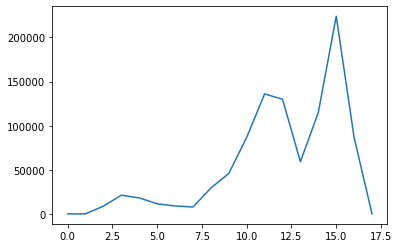

In [206]:
plt.plot(df_recovered)


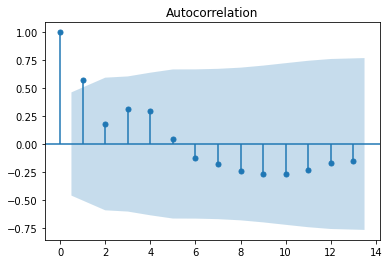

In [207]:
plot_acf(df_recovered)
plt.show()

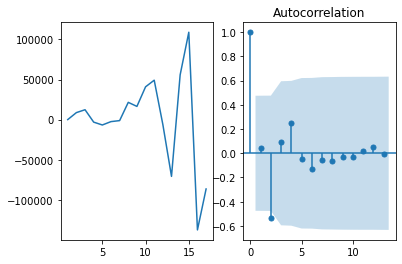

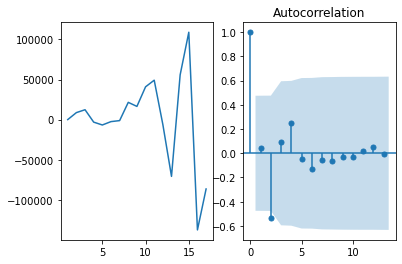

In [208]:
fig, (ax1,ax2) = plt.subplots(1,2)
ax1.plot(df_recovered.diff())
plot_acf(df_recovered.diff().dropna(), ax=ax2)

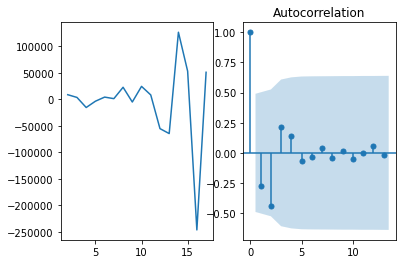

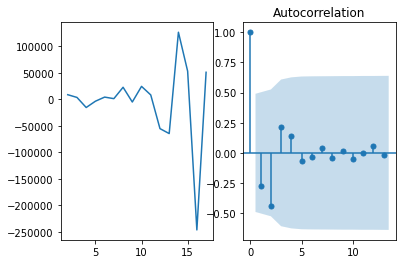

In [209]:
fig, (ax1,ax2) = plt.subplots(1,2)
ax1.plot(df_recovered.diff().diff())
plot_acf(df_recovered.diff().diff().dropna(), ax=ax2)

In [211]:
from statsmodels.tsa.stattools import adfuller
results = adfuller(df_recovered.dropna())
print('p-value = ',results[1])
results = adfuller(df_recovered.diff().dropna())
print('p-value = ',results[1])
results = adfuller(df_recovered.diff().diff().dropna())
print('p-value = ',results[1])

p-value =  1.0
p-value =  0.19919553843834964
p-value =  0.0005283373608598522


In [212]:
p = 1
d = 1
q = 2

#### Chọn p = 1, d = 1, q =2

#### Chia thành 2 tập train và test theo tỉ lệ 3/4

In [215]:
size = int(len(df_recovered) * 0.75)
train, test = df_recovered.iloc[:size], df_recovered.iloc[size:]


<AxesSubplot:>

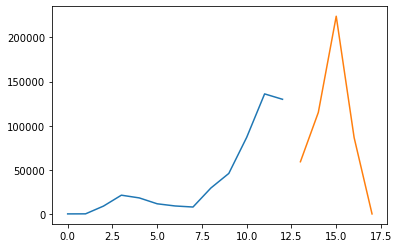

In [216]:
train.plot()
test.plot()


In [223]:
model = ARIMA(train, order = (1,1,2))
model_fit = model.fit()
pred = model_fit.predict(size, len(df_recovered) - 1)


#### So sánh tập test và predict

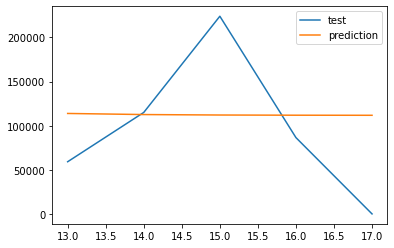

In [224]:
plt.plot(test, label = 'test')
plt.plot(pred, label = 'prediction')
plt.legend()
plt.show()


#### RMSE để đánh giá kết quả predict

In [225]:
print('RMSE: ', sqrt(mse(test, pred)))


RMSE:  75743.97038620383


In [226]:
forecast = model_fit.forecast(50)


#### Visualize kết quả forecast

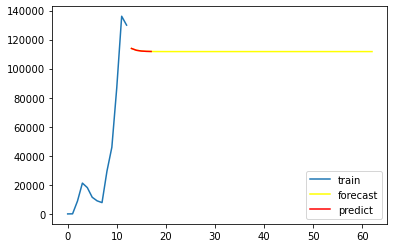

In [227]:
fig, ax = plt.subplots()
ax.plot(train)
ax.plot(forecast, color = 'yellow')
ax.plot(pred, color = 'red')
ax.legend(['train','forecast','predict'])
